# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.060839,False,-0.259543
1,-0.419574,False,-0.740519
2,0.716931,True,6.173856
3,-0.481055,True,4.915519
4,-0.083388,False,1.080534
...,...,...,...
995,0.722487,False,1.891804
996,-0.132578,True,7.072130
997,1.101248,True,6.097478
998,-0.900302,True,4.984944


<Axes: xlabel='v0'>

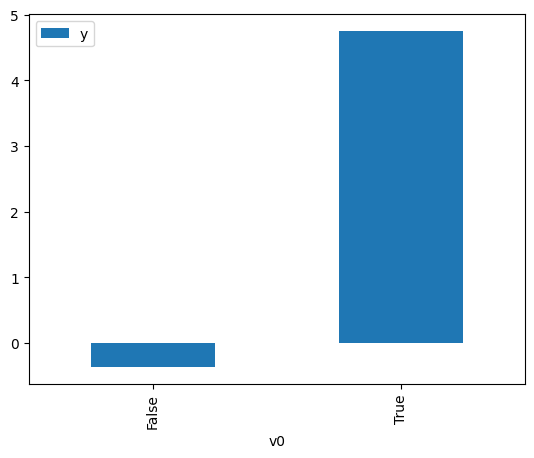

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

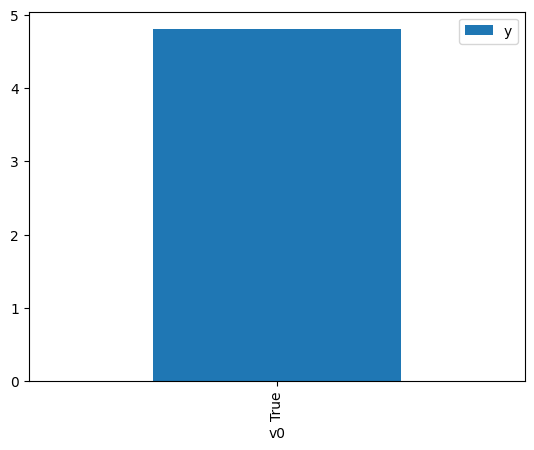

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.472596,False,0.376979,0.335229,2.983034
1,-0.946082,False,-0.923039,0.803056,1.245243
2,-0.577249,False,-0.082757,0.703101,1.422272
3,0.989284,False,-0.755141,0.190639,5.245508
4,0.142805,False,0.519932,0.450476,2.219874
...,...,...,...,...,...
995,-0.577249,False,-0.082757,0.703101,1.422272
996,0.088640,False,1.809895,0.470298,2.126310
997,0.898391,False,1.260004,0.212161,4.713404
998,-0.553143,False,-1.030329,0.695634,1.437538


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.225062,True,7.365203,0.857323,1.166421
1,1.189363,True,6.583960,0.850768,1.175409
2,1.101248,True,6.097478,0.833525,1.199724
3,-1.038436,True,3.078137,0.176307,5.671923
4,0.195169,True,6.001011,0.568540,1.758892
...,...,...,...,...,...
995,0.310579,True,5.725883,0.609671,1.640229
996,0.129829,True,5.838307,0.544787,1.835579
997,0.755889,True,6.469686,0.750635,1.332205
998,1.430036,True,7.133408,0.890438,1.123043


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7491.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):                        0.00
Time:                        16:17:46   Log-Likelihood:                         -1396.3
No. Observations:                1000   AIC:                                      2797.
Df Residuals:                     998   BIC:                                      2807.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1784      0.034     35.056      0.000       1.112       1.244
x2             4.9369      0.047    104.140      0.000       4.844       5.030
==============================================================================
Omnibus:                        0.539   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.419
Skew:                           0.025   Prob(JB):                        0.811
Kurtosis:                       3.087   Cond. No.                         1.55
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""